In [1]:
%matplotlib inline
from common_imports import *

Couldn't import dot_parser, loading of dot files will not be possible.


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
H = W = 10
grid = np.zeros((H, W))
# use diagnoal.
# pos_list = [(0,0), (1,1), (2,2), (3,3), (4,4), (5,5), (6,6), (7,7), (8,8)]
# use all.
pos_list = []
for h in range(0, H, 2):
    for w in range(0, W, 2):
        if (h, w) == (H-1, W-1):
            continue
        pos_list.append((w, h))

tasks = [GridWorldFixedStart(pos, grid=grid, action_stoch=0.2, goal={(H-1, W-1): 1.}, rewards={(H-1, W-1): 1.,}, wall_penalty=0., gamma=0.9)
         for pos in pos_list]
test_pos_list = [(0,0), (3,3), (6,6), (8,8)]
test_tasks = [GridWorldFixedStart(pos, grid=grid, action_stoch=0.2, goal={(H-1, W-1): 1.}, rewards={(H-1, W-1): 1.,}, wall_penalty=0., gamma=0.9)
         for pos in test_pos_list]
task0 = tasks[0]

In [3]:
# create the task.
state_shape = task0.state_shape
task = task0
# define potential neural network architectures.
def two_layer(states):
    '''
    two layer neural network with same number of hidden units.
    '''
    state_vecs = states.flatten(2)
    return arch.two_layer(state_vecs, np.prod(task.state_shape), 128, task.num_actions)

def conv_net(states):
    '''
    conv+max-pool layer first followed by a fully-connected layer.
    '''
    conv1 = Conv(input_dim=state_shape[0], output_dim=32, filter_size=(2,2), pool_size=(2,2), activation='relu')
    h1 = conv1(states)
    h1_dim = int((state_shape[1]-2+1)/2) * int((state_shape[2]-2+1)/2) * 32
    h1 = h1.flatten(2)
    fc1 = FullyConnected(input_dim=h1_dim, output_dim=32, activation='relu')
    h2 = fc1(h1)
    linear_layer = FullyConnected(input_dim=32, output_dim=task.num_actions, activation=None)
    output = linear_layer(h2)
    return (output, {
        'conv1': conv1,
        'fc1': fc1,
        'linear_layer': linear_layer
    })




# meta-feature extractors.

In [4]:
def feat_goal_dist(task):
    return np.abs(task.start_pos[0] - W + 1) + np.abs(task.start_pos[1] - H + 1)

def feat_dist(task_a, task_b):
    return np.abs(task_a.start_pos[0] - task_b.start_pos[0]) + np.abs(task_a.start_pos[1] - task_b.start_pos[1])

def mf_goal_dist_interval(im_mem, curr_task, interval, win_size):
    curr_feat = feat_goal_dist(curr_task)
    if curr_feat < interval[0] or curr_feat >= interval[1]:
        return 0.
    avg_im = 0.
    avg_count = 0
    win_count = 0
    for (task, im) in im_mem[::-1]:
        feat = feat_goal_dist(task)
        if feat >= interval[0] and feat < interval[1]:
            avg_im += im
            avg_count += 1
            win_count += 1
            if win_count >= win_size:
                break
    if avg_count == 0:
        return 0.
    else:
        return avg_im / avg_count

def mf_nb(im_mem, curr_task):
    avg_im = 0.
    for (task, im) in im_mem[::-1]:
        dist = feat_dist(task, curr_task)
        avg_im += np.exp(1.-dist) * im
        if task == curr_task:
            break
    return avg_im
        
    
def mf_goal(im_mem, curr_task):
    win_size = 3
    avg_im = 0.
    avg_count = 0
    win_count = 0
    for (task, im) in im_mem[::-1]:
        if task == curr_task:
            avg_im += im
            avg_count += 1
            win_count += 1
            if win_count >= win_size:
                break
    if avg_count == 0:
        return 0.
    else:
        return avg_im / avg_count
            

def mf_goal_dist_gen(interval, win_size):
    class MFGoalDist(object):
        def __call__(self, im_mem, curr_task):
            return mf_goal_dist_interval(im_mem, curr_task, interval, win_size)
        
        def __repr__(self):
            return str(interval) + '-' + str(win_size)
    return MFGoalDist()

# intervals = [(0, 5), (3, 8), (5, 10), (8, 13), (10, 15), (13, 18), (15, 20)]
# dists = [feat_goal_dist(task) for task in tasks]
# intervals = [(dist, dist+1) for dist in dists]
# mf_goal_dist_exs = [mf_goal_dist_gen(interval, win_size=3) for interval in intervals]
# mf_goal_exs = [mf_goal]
mf_exs = [mf_nb]

# Train and Eval funcs

In [23]:
dqn = DQN(task0, arch_func=two_layer, state_type=T.tensor4)



In [24]:
learner = DeepQlearn(dqn, gamma=0.9, lr=1e-3, memory_size = 1000, epsilon=0.3)
budget = 5
tol=1e-4
train_func = lambda task:  learner.run(task, num_episodes = 1, tol=tol, budget=budget)
# eval_func = lambda policy, task: reward_stochastic(policy, task, gamma=tol**(1. / budget), num_trials=100, tol=tol)
eval_func = lambda policy, task: qval_stochastic(policy, task, gamma=0.9, budget=budget, num_trials=100, tol=tol)

In [25]:
meta = DQCL.DriftExpert(dqn, mf_exs, train_func, eval_func, eta=1/20.)

In [26]:
start_locs = []
ims = []
scores = []
exs = []
for it in range(100):
    meta.run(tasks, num_epochs=1)
    print 'iteration', it
    print 'count'
    pprint(meta.task_count)
    print 'pred'
    pprint(meta.im_pred)
    print 'ucb'
    pprint(meta.im_ucb)
    print 'meta features'
    pprint(meta.im_feat)
    print 'im_mem'
    pprint(meta.im_mem)
    pprint(meta.diagnostics)
    ims.append(meta.diagnostics['score after'] - meta.diagnostics['score before'])
    start_locs.append(meta.diagnostics['task chosen'].start_pos)
    print '---------------------------------------'
    if (it + 1) % 10 == 0:
        test_score = {}
        for test_task in test_tasks:
            test_score[test_task.start_pos] = reward_stochastic(dqn, test_task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)
        scores.append(test_score)
        exs.append(learner.total_exp)
        
        

iteration 0
count
{(0, 0) -> (9, 9): 1,
 (2, 0) -> (9, 9): 0,
 (4, 0) -> (9, 9): 0,
 (6, 0) -> (9, 9): 0,
 (8, 0) -> (9, 9): 0,
 (0, 2) -> (9, 9): 0,
 (2, 2) -> (9, 9): 0,
 (4, 2) -> (9, 9): 0,
 (6, 2) -> (9, 9): 0,
 (8, 2) -> (9, 9): 0,
 (0, 4) -> (9, 9): 0,
 (2, 4) -> (9, 9): 0,
 (4, 4) -> (9, 9): 0,
 (6, 4) -> (9, 9): 0,
 (8, 4) -> (9, 9): 0,
 (0, 6) -> (9, 9): 0,
 (2, 6) -> (9, 9): 0,
 (4, 6) -> (9, 9): 0,
 (6, 6) -> (9, 9): 0,
 (8, 6) -> (9, 9): 0,
 (0, 8) -> (9, 9): 0,
 (2, 8) -> (9, 9): 0,
 (4, 8) -> (9, 9): 0,
 (6, 8) -> (9, 9): 0,
 (8, 8) -> (9, 9): 0}
pred
{(0, 0) -> (9, 9): 0.0,
 (2, 0) -> (9, 9): 0.0,
 (4, 0) -> (9, 9): 0.0,
 (6, 0) -> (9, 9): 0.0,
 (8, 0) -> (9, 9): 0.0,
 (0, 2) -> (9, 9): 0.0,
 (2, 2) -> (9, 9): 0.0,
 (4, 2) -> (9, 9): 0.0,
 (6, 2) -> (9, 9): 0.0,
 (8, 2) -> (9, 9): 0.0,
 (0, 4) -> (9, 9): 0.0,
 (2, 4) -> (9, 9): 0.0,
 (4, 4) -> (9, 9): 0.0,
 (6, 4) -> (9, 9): 0.0,
 (8, 4) -> (9, 9): 0.0,
 (0, 6) -> (9, 9): 0.0,
 (2, 6) -> (9, 9): 0.0,
 (4, 6) -> (9, 9): 

In [69]:
learner.total_exp

4981

In [60]:
test_score = {}
for test_task in test_tasks:
    test_score[test_task.start_pos] = reward_stochastic(dqn, test_task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)
pprint(test_score)

{(0, 0): 0.019490595573741422,
 (3, 3): 0.21392649962378041,
 (6, 6): 0.51751241971932582,
 (8, 8): 0.87084790596090078}


In [137]:
i = 23
print tasks[i]
reward_stochastic(dqn, tasks[i], gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)

(6, 8)


0.0

In [131]:
pprint(test_score)

{(0, 0): 0.0, (3, 3): 0.0, (6, 6): 0.0, (8, 8): 0.0090000000000000011}


In [125]:
exs

[500, 1000, 1500, 2000, 2500]

In [113]:
print tasks[15]

(0, 6)


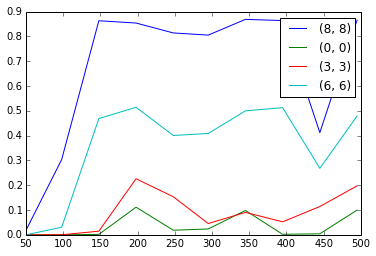

In [27]:
def plot_scores():
    keys = scores[0].keys()
    xs = exs
    for key in keys:
        ys = [score[key] for score in scores]
        plot(xs, ys)
    legend(keys)
    show()
plot_scores()

## Baseline

In [28]:
task = test_tasks[0]
dqn = DQN(task, arch_func=two_layer, state_type=T.tensor4)
learner = DeepQlearn(dqn, gamma=0.9, lr=1e-3, memory_size = 1000, epsilon=0.1)
scores = []
exs = []
tol = 1e-4
for it in range(40):
    learner.run(task, num_episodes=1, tol=tol)
    if (it + 1) % 1 == 0:
        test_score = {}
        for test_task in test_tasks:
            test_score[test_task.start_pos] = reward_stochastic(dqn, test_task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)
        scores.append(test_score)
        exs.append(learner.total_exp)
    print 'it', it




it 0
it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
it 10
it 11
it 12
it 13
it 14
it 15
it 16
it 17
it 18
it 19
it 20
it 21
it 22
it 23
it 24
it 25
it 26
it 27
it 28
it 29
it 30
it 31
it 32
it 33
it 34
it 35
it 36
it 37
it 38
it 39


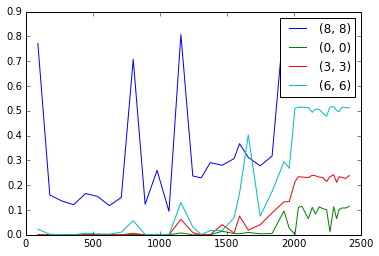

In [29]:
plot_scores()

## Visualization

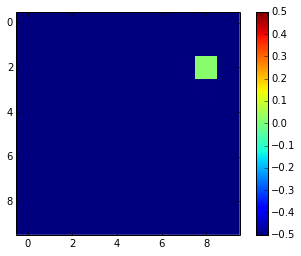

In [138]:

from ipywidgets import widgets, interact

def make_plot(i):
    (loc, im) = (start_locs[i], ims[i])
    grid = np.ones((H, W)) * -1.
    grid[loc] = im
    imshow(grid, interpolation='none', vmin=-.5, vmax=.5)
    colorbar()

interact(make_plot, i=(0,len(ims),1))
